# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# installing packages
#!pip install wordcloud

In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
from itertools import chain

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
# flattens list of lists
def flatten_list(token_lists):
    return list(chain.from_iterable(token_lists))



def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # flattening the string
    flat_tokens = [token for token in tokens if not isinstance(token,float)]
    num_tokens = len(flat_tokens) # number of tokens
    num_unique_tokens = len(set(flat_tokens)) # number of unique tokens
    lexical_diversity = num_unique_tokens/num_tokens  # lexical diversity
    num_characters = sum(len(token) for token in flat_tokens) # number of characters
    most_common_tokens = Counter(flat_tokens).most_common(num_tokens)[0:5] # most common tokens
    
    # print statistics if verbose is True
    if verbose:
        print(f"Number of tokens: {num_tokens}")
        print(f"Number of unique tokens: {num_unique_tokens}")
        print(f"Number of characters: {num_characters}")
        print(f"Lexical diversity: {lexical_diversity:.2f}")
        print(f"Most common tokens: {most_common_tokens}")
    
    
    # returns a list of statistics
    return ([num_tokens, num_unique_tokens, num_characters, lexical_diversity, most_common_tokens])

def new_descriptive_stats(tokens, num_tokens = 5 , verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    flat_tokens = [token for sublist in tokens if isinstance(sublist, list) for token in sublist if not isinstance(token, float)]
    total_tokens = len(flat_tokens)  # total number of tokens
    num_tokens = len(flat_tokens) # number of tokens
    num_unique_tokens = len(set(flat_tokens)) # number of unique tokens
    lexical_diversity = num_unique_tokens/num_tokens  # lexical diversity
    num_characters = sum(len(token) for token in flat_tokens) # number of characters
    most_common_tokens = Counter(flat_tokens).most_common(num_tokens)[0:5] # most common tokens
   
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    print(f"The five most common tokens are {most_common_tokens} in the data.")      
    
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    cleaned_tokens = [token for token in tokens if token not in sw]
    
    return(cleaned_tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # fold to lowercase and split on whitespace
    new_text = text.lower().split()
    
    return(new_text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

def remove_song_titles(text):
    """
    Extract everything after the fourth quotation mark, removing the fourth quotation mark
    and any whitespace before the word following it.
    """
    # find the fourth quote
    fourth_quote_index = text.find('"', text.find('"', text.find('"', text.find('"') + 1) + 1) + 1)

    if fourth_quote_index == -1:
        return text  # If the fourth quote is not found, return the original text

    # find the next non-whitespace character after the fourth quote
    next_non_whitespace_index = fourth_quote_index + 1
    while next_non_whitespace_index < len(text) and text[next_non_whitespace_index].isspace():
        next_non_whitespace_index += 1

    # return text starting from after the fourth quote, excluding the fourth quote and leading whitespace
    return text[next_non_whitespace_index:]


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/jessh/Documents/ADS509/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# read in the lyrics here
# getting the path to the lyrics folder
folder_path = data_location + lyrics_folder

# List to store all file paths
all_file_paths = []

# go through all directories and subdirectories
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        all_file_paths.append(file_path)
        
# read the contents of each file and store them along with the filename using the folder_paths variable
file_data = []
for file_path in all_file_paths:
    with open(file_path, 'r') as file:
        content = file.read()
        filename = os.path.relpath(file_path, folder_path) # Get the relative path as filename
        filename = os.path.basename(filename) # only getting the filename of whatever we pulled
        file_data.append((filename, content))

# create a dataframe with columns 'Filename' and 'File Content'
lyrics_df = pd.DataFrame(file_data, columns=['Filename', 'File Content'])

# Display the dataframe
lyrics_df.head(5)

,Filename,File Content
0,dualipa_badtogether.txt,"""Bad Together"" lyrics\n\nDua Lipa Lyrics\n\n\n..."
1,dualipa_begging.txt,"""Begging"" lyrics\n\nDua Lipa Lyrics\n\n\n\n\n""..."
2,dualipa_betheone.txt,"""Be The One"" lyrics\n\nDua Lipa Lyrics\n\n\n\n..."
3,dualipa_blowyourmindmwah.txt,"""Blow Your Mind (Mwah)"" lyrics\n\nDua Lipa Lyr..."
4,dualipa_dreams.txt,"""Dreams"" lyrics\n\nDua Lipa Lyrics\n\n\n\n\n""D..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# removing song titles in the file content
lyrics_df['File Content'] = lyrics_df['File Content'].apply(remove_song_titles)

In [9]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_df["tokens"] = lyrics_df["File Content"].apply(prepare,pipeline=my_pipeline)
lyrics_df["num_tokens"] = lyrics_df["tokens"].map(len) 

In [10]:
lyrics_df.head(5)

,Filename,File Content,tokens,num_tokens
0,dualipa_badtogether.txt,"Know you're bad for me, but you know I am too\...","[know, youre, bad, know, together, like, loved...",262
1,dualipa_begging.txt,All of these highs\nAnd all of these lows\nDon...,"[highs, lows, dont, keep, company, ive, breath...",157
2,dualipa_betheone.txt,"I see the moon, I see the moon, I see the moon...","[see, moon, see, moon, see, moon, oh, youre, l...",175
3,dualipa_blowyourmindmwah.txt,I know it's hot\nI know we've got\nSomething t...,"[know, hot, know, weve, got, something, money,...",236
4,dualipa_dreams.txt,"Last night, my fantasies become oh-so true\nYo...","[last, night, fantasies, become, ohso, true, s...",262


In [11]:
twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [12]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

In [13]:
twitter_data.head(10)

,screen_name,name,id,location,followers_count,friends_count,description,artist,tokens,num_tokens,has_emoji
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher,[nan],1,False
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]",6,False
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]",3,True
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher,[csu],1,False
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher,"[writer, washinformer, spelmancollege, alumna,...",17,False
5,liaochaoqun2,廖超群,1502787622376075264,Taiwan,2,390,NaN,cher,[nan],1,False
6,Rodhandyjj,Art Vandalay 🇺🇦🇺🇦🇺🇦,1386454132022824962,"Maine, USA",104,159,I’m unemployed and live with my parents. MOOPS!,cher,"[i’m, unemployed, live, parents, moops]",5,False
7,JackBianchi7,Jackson,1200870825953550336,NaN,0,7,zoowee mama,cher,"[zoowee, mama]",2,False
8,MelbaBu81266475,Melba Burns,1492913469166743554,NaN,17,136,NaN,cher,[nan],1,False
9,macryant900,SpyderRyder,3425156986,🇨🇦,628,794,Let the healing begin. Let us learn from the p...,cher,"[let, healing, begin, let, us, learn, past, 🇨🇦...",10,False


Let's take a quick look at some descriptions with emojis.

In [14]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
570271,cher,rest in paradise мσммα ∂υкєѕ 83-16😇💕🐢 Boy mom💙...,"[rest, paradise, мσммα, ∂υкєѕ, 8316😇💕🐢, boy, m..."
2309336,cher,I am Kath got three lovely kids 2 boys & 1 gir...,"[kath, got, three, lovely, kids, 2, boys, 1, g..."
3660945,cher,"📊 Data Analyst, 🎤 Singer, 😺 Cat Lover, 👩🏻‍🎨 Cr...","[📊, data, analyst, 🎤, singer, 😺, cat, lover, 👩..."
58141,cher,fierce diva 💋 she/her he/him,"[fierce, diva, 💋, sheher, hehim]"
1353488,cher,resistance !!! healthcare. vote Blue!!! follow...,"[resistance, healthcare, vote, blue, follow, d..."
879925,cher,Living the dream! 🐥,"[living, dream, 🐥]"
703757,cher,Little Monster for life 💚 ''LOVE and PEACE'' ♥,"[little, monster, life, 💚, love, peace, ♥]"
1346720,cher,I Dare to be Different!!! Music Soothes My Sou...,"[dare, different, music, soothes, soul, 🎶, jah..."
3072353,cher,I love Troian Bellisario so much. She means th...,"[love, troian, bellisario, much, means, world,..."
777276,cher,entertainer • businessman • sassy GBF to many ...,"[entertainer, •, businessman, •, sassy, gbf, m..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I could probably see if there are bigrams like "proud blank" or "love you" to further enhance our tokenization efforts. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [15]:
# splitting based on artist for lyrics
dualipa_lyrics_df = lyrics_df[lyrics_df['Filename'].str.contains('dualipa', case = False)].reset_index()
hozier_lyrics_df = lyrics_df[lyrics_df['Filename'].str.contains('hozier', case = False)].reset_index()

# get descriptive statistics for the artists
print(new_descriptive_stats(dualipa_lyrics_df['tokens']))
print(new_descriptive_stats(hozier_lyrics_df['tokens']))

There are 3499 tokens in the data.
There are 638 unique tokens in the data.
There are 16085 characters in the data.
The lexical diversity is 0.182 in the data.
The five most common tokens are [('dont', 99), ('love', 86), ('im', 81), ('know', 79), ('like', 61)] in the data.
[3499, 638, 0.1823378108030866, 16085]
There are 2813 tokens in the data.
There are 938 unique tokens in the data.
There are 14061 characters in the data.
The lexical diversity is 0.333 in the data.
The five most common tokens are [('power', 49), ('love', 46), ('little', 41), ('oh', 33), ('like', 30)] in the data.
[2813, 938, 0.3334518307856381, 14061]


Q: what observations do you make about these data? 

A: For both artist's top 5 words, "love" and "like" show up on both lists. This was different that in the last assignment where I ran the descriptive statistics on the actual lyrics and not on the tokens. Both artists also have fairly low lexical diversity, but i guess that's to be expected as the chorus in songs are usually repeated - probably affecting the lexical diversity.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [16]:
# I have to flatten the list within the dataframe first

# Step 1: Count occurrences of each token in each corpus
corpus_counts = twitter_data.groupby('artist')['tokens'].apply(lambda x: Counter(flatten_list(x))).to_dict()
dualipa_counts = dualipa_lyrics_df['tokens'].apply(lambda x: Counter(x)).to_dict()
hozier_counts = hozier_lyrics_df['tokens'].apply(lambda x: Counter(x)).to_dict()

The dictionary for dualipa and hozier had the outer counter portion. I didn't like that so i got rid of it to combine all the tokens into one dictionary.

In [17]:
# Combine all dictionaries into one
new_dualipa_count = {}
for counter_object in dualipa_counts.values():
    new_dualipa_count.update(dict(counter_object))

new_hozier_count ={}
for counter_object in hozier_counts.values():
    new_hozier_count.update(dict(counter_object))

There were a lot of tweets that had nothing in it, so i decided to get rid of it but i first noted the counts it had 1994086.0.

In [18]:
# new dictionary without the first element in the dictionary
del corpus_counts[list(corpus_counts.keys())[0]]

In [19]:
corpus_counts

{('cher', '𝙿𝚛𝚘𝚞𝚍'): 1.0,
 ('cher', '𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛'): 2.0,
 ('cher', '𝚘𝚏'): 49.0,
 ('cher', '𝚖𝚎𝚜𝚜𝚢'): 1.0,
 ('cher', '𝚋𝚞𝚗𝚜'): 1.0,
 ('cher', '𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜'): 1.0,
 ('cher', '163㎝／愛かっぷ💜26歳🍒'): 1.0,
 ('cher', '工〇好きな女の子💓'): 1.0,
 ('cher', 'フォローしてくれたらdmします🧡'): 1.0,
 ('cher', 'csu'): 105.0,
 ('cher', 'writer'): 28855.0,
 ('cher', 'washinformer'): 1.0,
 ('cher', 'spelmancollege'): 7.0,
 ('cher', 'alumna'): 1063.0,
 ('cher', '#dcnative'): 5.0,
 ('cher', 'awardwinning'): 949.0,
 ('cher', 'journalist'): 4736.0,
 ('cher', 'pr'): 2973.0,
 ('cher', 'pro'): 4661.0,
 ('cher', 'iabc'): 4.0,
 ('cher', 'fellow'): 1731.0,
 ('cher', 'past'): 3134.0,
 ('cher', 'chair'): 1075.0,
 ('cher', 'ig'): 11085.0,
 ('cher', 'bcscomm'): 1.0,
 ('cher', 'email'): 3428.0,
 ('cher', 'wibsilergmailcom'): 1.0,
 ('cher', 'i’m'): 22711.0,
 ('cher', 'unemployed'): 196.0,
 ('cher', 'live'): 46419.0,
 ('cher', 'parents'): 1259.0,
 ('cher', 'moops'): 1.0,
 ('cher', 'zoowee'): 1.0,
 ('cher', 'mama'): 5793.0,
 ('cher', 'let'): 9477.0,
 ('c

In [20]:
# Sort the dictionary by value in descending order
sorted_dict = dict(sorted(corpus_counts.items(), key=lambda item: item[1], reverse=True))
sorted_dualipa = dict(sorted(new_dualipa_count.items(), key=lambda item: item[1], reverse=True))
sorted_hozier = dict(sorted(new_hozier_count.items(), key=lambda item: item[1], reverse=True))

In [21]:
sorted_dualipa

{'goodbyes': 28,
 'eden': 26,
 'cant': 23,
 'knock': 21,
 'together': 16,
 'mwah': 15,
 'begging': 14,
 'beg': 14,
 'garden': 14,
 'stop': 13,
 'tell': 12,
 'get': 12,
 'hell': 12,
 'bout': 11,
 'thinking': 11,
 'guaranteed': 11,
 'blow': 11,
 'dance': 11,
 'new': 11,
 'rules': 11,
 'count': 11,
 'em': 11,
 'beginning': 10,
 'give': 9,
 'swear': 9,
 'tonight': 9,
 'youd': 9,
 'hotter': 9,
 'better': 8,
 'youll': 8,
 'fuck': 8,
 'alive': 8,
 'dollar': 8,
 'sign': 8,
 'feel': 8,
 'gotta': 8,
 'wish': 8,
 'got': 7,
 'fall': 7,
 'come': 7,
 'back': 7,
 'around': 7,
 'kiss': 7,
 'comes': 7,
 'push': 7,
 'shove': 7,
 'tumblin': 7,
 'karmas': 7,
 'know': 6,
 'go': 6,
 'ive': 6,
 'lets': 6,
 'love': 6,
 'tame': 6,
 'right': 6,
 'edenâ€¦': 6,
 'miguel': 6,
 'alright': 6,
 'harder': 6,
 'hes': 6,
 'make': 5,
 'break': 5,
 'forever': 5,
 'bones': 5,
 'hey': 5,
 'walk': 5,
 'cut': 5,
 'eh': 5,
 'wont': 4,
 'dont': 4,
 'cause': 4,
 'need': 4,
 'want': 4,
 'really': 4,
 'think': 4,
 'heaven': 4,
 's

In [22]:
# Filter items with values greater than 5
filtered_dualipa = {key: value for key, value in sorted_dualipa.items() if value > 5}
filtered_hozier = {key: value for key, value in sorted_hozier.items() if value > 5}
filtered_corpus = {key: value for key, value in sorted_dict.items() if value > 5}

In [23]:
# Step 2: Calculate the ratio of appearances in a given corpus vs appearances in other corpora
new_df = pd.DataFrame(list(filtered_corpus.items()), columns = ['Artist_Token','Count'])

# Split 'Artist_Token' column into 'Artist' and 'Token'
new_df[['Artist', 'Token']] = pd.DataFrame(new_df['Artist_Token'].tolist(), index=new_df.index)

# Drop the original 'Artist_Token' column
new_df.drop(columns=['Artist_Token'], inplace=True)

new_df = new_df[['Artist', 'Token', 'Count']]

cher_new_df = new_df[new_df['Artist'].str.contains('cher', case = False)].reset_index(drop = True)
robyn_new_df = new_df[new_df['Artist'].str.contains('robyn', case = False)].reset_index(drop = True)

In [24]:
# check to see if the word exists in the tweets for robyn
def check_token_exists(token):
    return token in robyn_new_df['Token'].values
    
# Create a new column with information about token existence
cher_new_df['Exists in robyn tweets'] = cher_new_df['Token'].apply(lambda x: check_token_exists(x))



In [25]:
# only get the ones that are True
cher_exists = cher_new_df[cher_new_df['Exists in robyn tweets'] == True]
cher_exists.head()

,Artist,Token,Count,Exists in robyn tweets
0,cher,love,213522.0,True
1,cher,im,139051.0,True
2,cher,life,122679.0,True
3,cher,music,86733.0,True
4,cher,de,72970.0,True


In [26]:
# merging the two dataframes on token
cher_robyn_df = pd.merge(cher_exists,robyn_new_df[['Token','Count']], on = 'Token')

# setting up concentration columns for each artists' tweets
cher_robyn_df['Ratio for cher'] = cher_robyn_df['Count_x']/sum(cher_robyn_df['Count_x'])
cher_robyn_df['Ratio for robyn'] = cher_robyn_df['Count_y']/sum(cher_robyn_df['Count_y'])

# Rename columns because I messed up
cher_robyn_df = cher_robyn_df.rename(columns={'Ratio for cher': 'Concentration 1', 'Ratio for robyn': 'Concentration 2'})

# getting the ratio
cher_robyn_df['Ratio'] = cher_robyn_df['Concentration 1']/cher_robyn_df['Concentration 2']

# getting the top 10 words based on ratio
top_cher_robyn = cher_robyn_df.nlargest(10,'Ratio')

Now we're going to do the same for the lyrics data.

In [27]:
hozier_words_df = pd.DataFrame(list(filtered_hozier.items()), columns= ['Token','Count'])
hozier_words_df['Artist'] = 'Hozier'
dualipa_words_df = pd.DataFrame(list(filtered_dualipa.items()), columns= ['Token','Count'])
dualipa_words_df['Artist'] = 'Dualipa'

In [28]:
# check to see if the word exists in the lyrics for both artists
def check_token_exists(token):
    return token in hozier_words_df['Token'].values

# Create a new column with information about token existence
dualipa_words_df['Exists in hozier lyrics'] = dualipa_words_df['Token'].apply(lambda x: check_token_exists(x))

There were only 4 words that we can work with for these lyrics.

In [29]:
# only get the ones that are True
dualipa_exists = dualipa_words_df[dualipa_words_df['Exists in hozier lyrics'] == True]
dualipa_exists.head()

,Token,Count,Artist,Exists in hozier lyrics
10,tell,12,Dualipa,True
18,new,11,Dualipa,True
38,fall,7,Dualipa,True
41,around,7,Dualipa,True


In [30]:
# merging the two dataframes on token
dua_hoz_df = pd.merge(dualipa_exists,hozier_words_df[['Token','Count']], on = 'Token')

# setting up concentration columns for each artists' tweets
dua_hoz_df['Concentration 1'] = dua_hoz_df['Count_x']/sum(dua_hoz_df['Count_x'])
dua_hoz_df['Concentration 2'] = dua_hoz_df['Count_y']/sum(dua_hoz_df['Count_y'])

# getting the ratio
dua_hoz_df['Ratio'] = dua_hoz_df['Concentration 1']/dua_hoz_df['Concentration 2']

In [31]:
print(top_cher_robyn)
print(dua_hoz_df)

     Artist           Token  Count_x  Exists in robyn tweets  Count_y  \
289    cher     grandmother   7132.0                    True     19.0   
707    cher            #fbr   3131.0                    True     12.0   
1174   cher        resister   1817.0                    True      7.0   
1071   cher            nana   2010.0                    True      8.0   
1420   cher          rbsoul   1530.0                    True      7.0   
381    cher         grandma   5705.0                    True     27.0   
686    cher  #theresistance   3211.0                    True     16.0   
885    cher       hiphoprap   2479.0                    True     13.0   
1648   cher             gop   1288.0                    True      7.0   
943    cher   grandchildren   2306.0                    True     13.0   

      Concentration 1  Concentration 2      Ratio  
289          0.000573         0.000016  34.874545  
707          0.000251         0.000010  24.241117  
1174         0.000146         0.000006  

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Between Cher and Robyn, there were more words to work with so here were more opporunities for words to be the top - granmother and grandma were among the top for the twitter posts suprisingly. For the lyrics data, there were only 4 words that were in common - tell, new, fall, around. Those words by itself don't really have a meaning as there's no context behind it (in my opinion). The top words for twitter were far more informative than the ones in the lyrics.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [32]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [62]:
# getting the two columns in the form of a dictionary
dualipa_count_dict = dict(zip(dualipa_words_df['Token'], dualipa_words_df['Count']))
hozier_count_dict = dict(zip(hozier_words_df['Token'], hozier_words_df['Count']))
cher_count_dict = dict(zip(cher_new_df['Token'], cher_new_df['Count']))
robyn_count_dict = dict(zip(robyn_new_df['Token'], robyn_new_df['Count']))

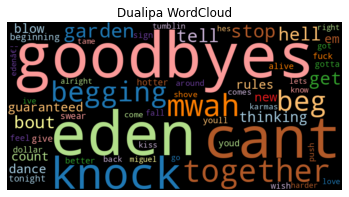

In [63]:
wordcloud(dualipa_count_dict, title = "Dualipa WordCloud")

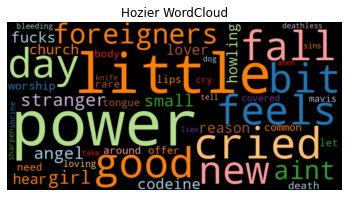

In [64]:
wordcloud(hozier_count_dict, title = "Hozier WordCloud")

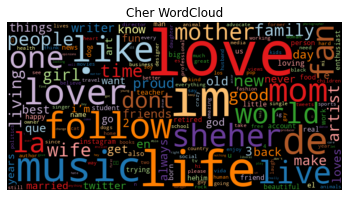

In [67]:
wordcloud(cher_count_dict, title = "Cher WordCloud")

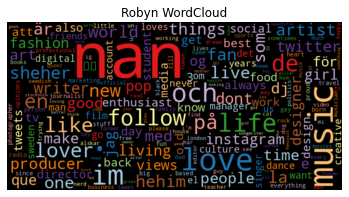

In [68]:
wordcloud(robyn_count_dict, title = "Robyn WordCloud")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: All of the wordclouds had one word that was that was "significant" except for the robyn wordcloud. The word with the most emphasis was "nan", meaning there were a lot of twitter entries that were empty. If you look at the same wordcloud, the next emphasized word is "music". I would probably guess people are posting something along the lines of "i love your music" or "I follow your music" using the context of the word cloud. In the cher wordcloud, the main one that stands out is love, which is a huge difference in comparison to the robyn tweets. In the dualipa wordcloud, her most used word was goodbye or eden. In the hozier wordcloud, his most used word was little or power. Very different wordclouds for different genres of music that they both specialize in.